In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


In this notebook, I used some code from illumidesk to look at many interactions between variables. I chose a few to include in the original model.

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [2]:
#df = pd.read_csv('C:/Users/umbac/Documents/Flatiron/Phase_2/project/bsc-phase-two-project/data/kc_house_data.csv')
df_cleaned = pd.read_csv('cleaned_df',index_col=0)
wf = pd.read_csv('Closest_WF',index_col=0)
medzip = pd.read_csv('mediandf.csv',index_col=0)

In [3]:
df = df_cleaned.join(wf)
df = df.join(medzip)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21577 entries, 0 to 21596
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       21577 non-null  int64  
 1   price                    21577 non-null  float64
 2   bedrooms                 21577 non-null  int64  
 3   bathrooms                21577 non-null  float64
 4   sqft_living              21577 non-null  int64  
 5   sqft_lot                 21577 non-null  int64  
 6   floors                   21577 non-null  float64
 7   waterfront               21577 non-null  float64
 8   view                     21577 non-null  float64
 9   condition                21577 non-null  int64  
 10  grade                    21577 non-null  int64  
 11  sqft_above               21577 non-null  int64  
 12  sqft_basement            21577 non-null  float64
 13  yr_built                 21577 non-null  int64  
 14  yr_renovated          

In [4]:
#there was a '?' in the column so i replaced with nan
df['sqft_basement'].replace('?',np.nan,inplace=True)
#then made column floats
df['sqft_basement'] = df['sqft_basement'].astype(float)
#calcd mean
base_sqft_mean = df['sqft_basement'].mean()
#placed nans with mean
df['sqft_basement'].fillna(base_sqft_mean,inplace=True)
# df.sqft_basement.unique()

In [5]:
df.isna().sum()

id                         0
price                      0
bedrooms                   0
bathrooms                  0
sqft_living                0
sqft_lot                   0
floors                     0
waterfront                 0
view                       0
condition                  0
grade                      0
sqft_above                 0
sqft_basement              0
yr_built                   0
yr_renovated               0
zipcode                    0
lat                        0
long                       0
sqft_living15              0
sqft_lot15                 0
reno                       0
price_per_sqft             0
year                       0
day                        0
month                      0
season                     0
sqft_living_times_grade    0
condition_div_grade        0
sqft_living_sq             0
bathrooms_sq               0
Closest_WF                 0
median_by_zip              0
dtype: int64

In [6]:
#remove 0s in yr_rend
df['yr_renovated'].fillna(0,inplace=True)
df['waterfront'].fillna(0,inplace=True)
df['view'].fillna(0,inplace=True)


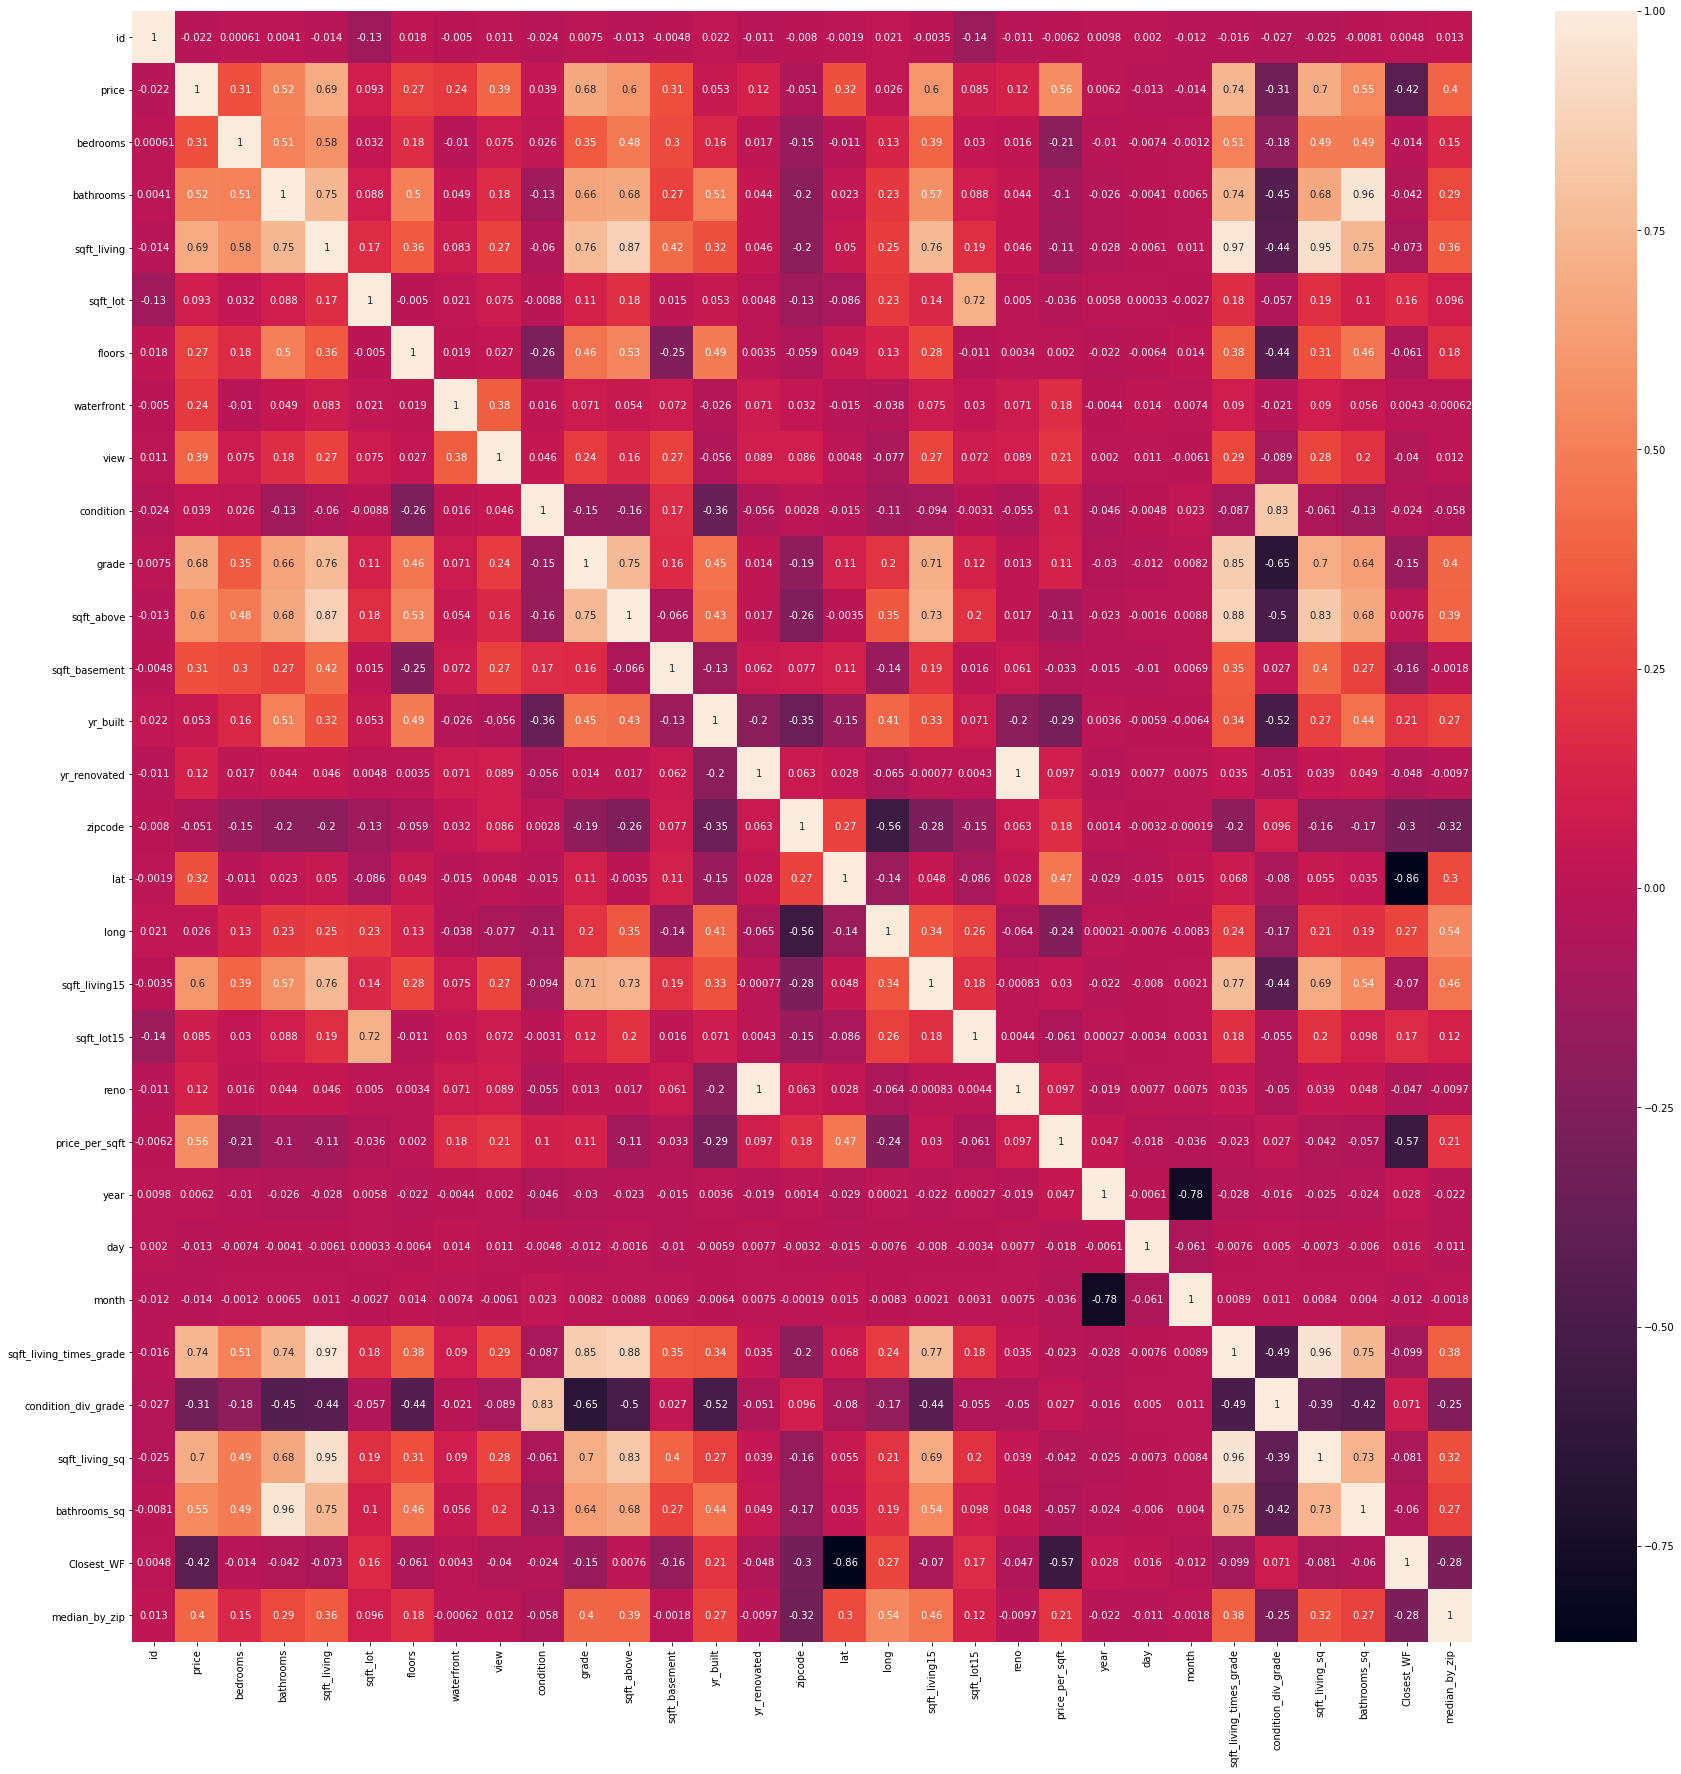

In [7]:
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(df.corr(),annot=True);

In [8]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'reno', 'price_per_sqft', 'year', 'day',
       'month', 'season', 'sqft_living_times_grade', 'condition_div_grade',
       'sqft_living_sq', 'bathrooms_sq', 'Closest_WF', 'median_by_zip'],
      dtype='object')

In [9]:
# cors = ['sqft_living15','sqft_above','grade','view','sqft_living','bathrooms','bedrooms']

# plt.style.use('fivethirtyeight')
# for column_name in df.columns:
#     plt.subplots(figsize=(10,10))
#     plt.scatter(df[f'{column_name}'],'price',data=df)
#     plt.legend()
#     plt.ylabel('Price')
#     plt.xlabel(f'{column_name}')



Make a base model with bed/bath, sqft_living, grade

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [11]:
reg = LinearRegression()

In [12]:
#what are my categories?
categoricals = ['bedrooms','bathrooms','waterfront','floors','view','grade','condition','zipcode','reno','season']
continuous = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15','year','day','month','sqft_living_times_grade','condition_div_grade','sqft_living_sq','bathrooms_sq','Closest_WF','median_by_zip']
df_cont = df[continuous]

In [13]:
df[categoricals]

,bedrooms,bathrooms,waterfront,floors,view,grade,condition,zipcode,reno,season
0,3,1.00,0.0,1.0,0.0,7,3,98178,0,fall
1,3,2.25,0.0,2.0,0.0,7,3,98125,1,winter
2,2,1.00,0.0,1.0,0.0,6,3,98028,0,winter
3,4,3.00,0.0,1.0,0.0,7,5,98136,0,winter
4,3,2.00,0.0,1.0,0.0,8,3,98074,0,winter
...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,0.0,3.0,0.0,8,3,98103,0,spring
21593,4,2.50,0.0,2.0,0.0,8,3,98146,0,winter
21594,2,0.75,0.0,2.0,0.0,7,3,98144,0,summer
21595,3,2.50,0.0,2.0,0.0,8,3,98027,0,winter


In [14]:
df_ohe = pd.get_dummies(df[categoricals])

preprocessed = pd.concat([df_cont, df_ohe],axis=1)

X = preprocessed.drop('price',axis=1)
y = preprocessed['price']

crossvalidation = KFold(n_splits=10,shuffle=True,random_state=1)
baseline = np.mean(cross_val_score(reg,X,y,scoring='r2',cv=crossvalidation))

baseline

0.7629734008823792

In [15]:
#Look at interactions
from itertools import combinations

In [16]:
preprocessed.columns
feat_combinations = combinations(X.columns,2)
len(list(feat_combinations))

496

In [29]:
# code to find top interactions by R^2 value here
interactions = []
# feat_combinations = combinations(X.columns,2)
feat_combinations = combinations(X[['Closest_WF','median_by_zip']],2)


data = X.copy()
for i, (a,b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(reg,data,y,scoring='r2',cv=crossvalidation,n_jobs=16))
    if score > baseline:
        interactions.append((a,b,round(score,3)))
        
    if i % 50 == 0:
        print(i)
        
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10])

0
Top 3 interactions: [('Closest_WF', 'median_by_zip', 0.763)]


In [18]:
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10])

Top 3 interactions: [('long', 'Closest_WF', 0.783), ('sqft_living_times_grade', 'Closest_WF', 0.781), ('sqft_living', 'Closest_WF', 0.779), ('long', 'sqft_living_times_grade', 0.779), ('long', 'grade', 0.779), ('sqft_living_sq', 'Closest_WF', 0.779), ('Closest_WF', 'grade', 0.779), ('yr_built', 'sqft_living15', 0.777), ('long', 'sqft_living_sq', 0.777), ('sqft_living', 'long', 0.775)]


In [30]:
# code to find top interactions by R^2 value here
interactions = []
# feat_combinations = combinations(X.columns,2)
feat_combinations = combinations(X[['Closest_WF','median_by_zip']],2)


data = X.copy()
for i, (a,b) in enumerate(feat_combinations):
    data['interaction'] = data[a] / data[b]
    score = np.mean(cross_val_score(reg,data,y,scoring='r2',cv=crossvalidation,n_jobs=16))
    if score > baseline:
        interactions.append((a,b,round(score,3)))
        
    if i % 50 == 0:
        print(i)
        
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
Top 3 interactions: [('Closest_WF', 'median_by_zip', 0.763)]


In [20]:
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:20])

Top 3 interactions: [('sqft_living_sq', 'Closest_WF', 0.787), ('sqft_living_times_grade', 'Closest_WF', 0.786), ('sqft_living', 'Closest_WF', 0.783), ('sqft_above', 'Closest_WF', 0.783), ('sqft_living15', 'Closest_WF', 0.78), ('bathrooms_sq', 'Closest_WF', 0.778), ('Closest_WF', 'grade', 0.776), ('sqft_living', 'long', 0.775), ('sqft_above', 'long', 0.772), ('sqft_living', 'yr_built', 0.771), ('sqft_basement', 'Closest_WF', 0.771), ('yr_built', 'Closest_WF', 0.771), ('lat', 'Closest_WF', 0.771), ('long', 'Closest_WF', 0.771), ('year', 'Closest_WF', 0.771), ('sqft_above', 'yr_built', 0.77), ('condition_div_grade', 'Closest_WF', 0.77), ('sqft_living', 'lat', 0.768), ('day', 'Closest_WF', 0.768), ('month', 'Closest_WF', 0.768)]


In [27]:
# code to find top interactions by R^2 value here
interactions = []
feat_combinations = combinations(X.columns,2)

data = X.copy()
for i, (a,b) in enumerate(feat_combinations):
    data['interaction'] = np.log(data[a]) + data[b]*0
    score = np.mean(cross_val_score(reg,data,y,scoring='r2',cv=crossvalidation,n_jobs=16))
    if score > baseline:
        interactions.append((a,round(score,3)))
        
    if i % 50 == 0:
        print(i)
        
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[1], reverse=True)[:20])

0
50


C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


100
150


C:\Users\umbac\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


200
250
300
350
400
450
Top 3 interactions: [('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('Closest_WF', 0.782), ('yr_built', 0.765), ('yr_built', 0.765), ('yr_built', 0.765), ('yr_built', 0.765), ('yr_built', 0.765), ('yr_built', 0.765)]


In [23]:
# code to find top interactions by R^2 value here
interactions = []
feat_combinations = combinations(X.columns,2)

data = X.copy()
for i, (a,b) in enumerate(feat_combinations):
    data['interaction'] = np.sqrt(abs(data[a]**2)) + data[b]*0
    score = np.mean(cross_val_score(reg,data,y,scoring='r2',cv=crossvalidation,n_jobs=16))
    if score > baseline:
        interactions.append((a,round(score,3)))
        
    if i % 50 == 0:
        print(i)
        
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[1], reverse=True)[:20])

0
50
100
150
200
250
300
350
400
450
Top 3 interactions: [('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763), ('sqft_above', 0.763)]


In [26]:
# code to find top interactions by R^2 value here
interactions = []
feat_combinations = combinations(X.columns,2)

data = X.copy()
for i, (a,b) in enumerate(feat_combinations):
    data['interaction'] = np.sqrt(abs(data[a])) * np.sqrt(abs(data[b]))
    score = np.mean(cross_val_score(reg,data,y,scoring='r2',cv=crossvalidation,n_jobs=16))
    if score > baseline:
        interactions.append((a,b,round(score,3)))
        
    if i % 50 == 0:
        print(i)
        
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:20])

0
50
100
150
200
250
300
350
400
450
Top 3 interactions: [('sqft_living_times_grade', 'Closest_WF', 0.798), ('sqft_living', 'Closest_WF', 0.797), ('sqft_living_sq', 'Closest_WF', 0.794), ('Closest_WF', 'grade', 0.792), ('sqft_living15', 'Closest_WF', 0.791), ('sqft_above', 'Closest_WF', 0.789), ('Closest_WF', 'bathrooms', 0.788), ('Closest_WF', 'bedrooms', 0.785), ('bathrooms_sq', 'Closest_WF', 0.784), ('yr_built', 'Closest_WF', 0.783), ('lat', 'Closest_WF', 0.783), ('long', 'Closest_WF', 0.783), ('year', 'Closest_WF', 0.783), ('Closest_WF', 'zipcode', 0.783), ('Closest_WF', 'condition', 0.78), ('Closest_WF', 'floors', 0.778), ('Closest_WF', 'median_by_zip', 0.776), ('long', 'sqft_living_sq', 0.775), ('yr_built', 'sqft_living_sq', 0.77), ('condition_div_grade', 'Closest_WF', 0.77)]
